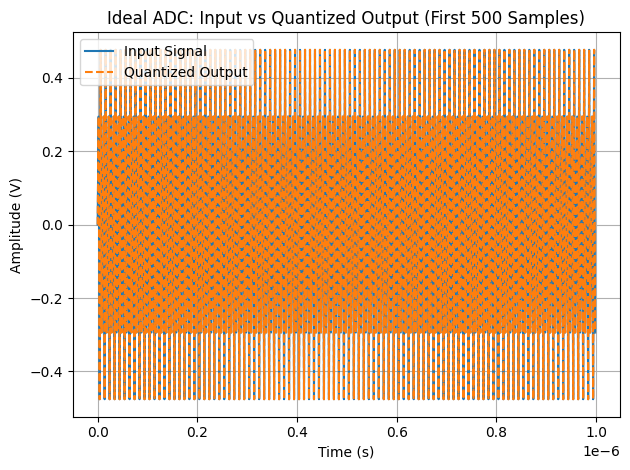

SNR (Ideal ADC): 19.67 dB


np.float64(19.668013434768945)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import pandas as pd

# --- Constants ---
fs = 500e6           # Sampling frequency
f_in = 200e6        # Input tone frequency
bits = 13            # ADC resolution
v_fs = 1.0           # Full-scale voltage (1V)
n_samples = 4096     # Number of FFT points

# --- Time vector and input signal ---
t = np.arange(n_samples) / fs
def generate_input_signal():
    return 0.5 * v_fs * np.sin(2 * np.pi * f_in * t)

# --- Ideal quantizer ---
def ideal_quantizer(signal):
    quant_levels = 2 ** bits
    step_size = v_fs / quant_levels
    return np.round(signal / step_size) * step_size

# --- SNR computation ---
def compute_snr(signal, fs, tone_freq):
    N = len(signal)
    window = np.hanning(N)
    Xf = fft(signal * window)
    Xf = np.abs(Xf[:N // 2])**2
    signal_bin = int(tone_freq / fs * N)
    signal_power = np.sum(Xf[signal_bin-1:signal_bin+2])
    noise_power = np.sum(Xf[1:]) - signal_power
    return 10 * np.log10(signal_power / noise_power)

# --- Simulation ---
def simulate_ideal_adc():
    x = generate_input_signal()
    xq = ideal_quantizer(x)
    snr = compute_snr(xq, fs, f_in)

    # Plot
    plt.figure()
    plt.plot(t[:500], x[:500], label='Input Signal')
    plt.plot(t[:500], xq[:500], label='Quantized Output', linestyle='--')
    plt.title('Ideal ADC: Input vs Quantized Output (First 500 Samples)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"SNR (Ideal ADC): {snr:.2f} dB")
    return snr

# --- Run ---
simulate_ideal_adc()


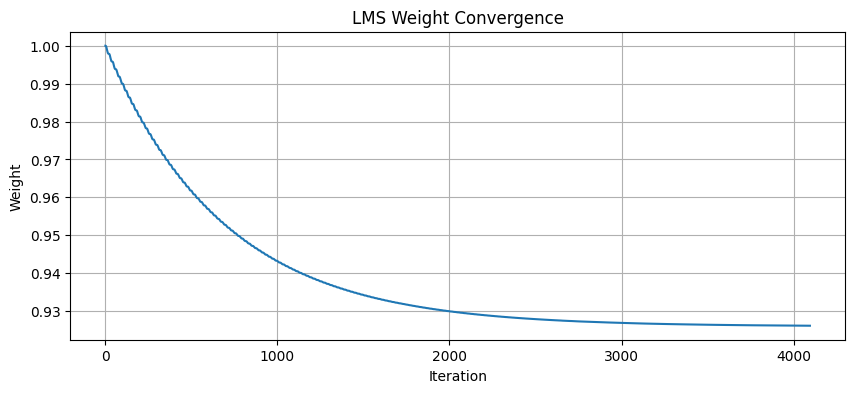

LMS Calibrated Final Weight: 0.9261
LMS Corrected SNDR: 56.36 dB


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# ----- Signal Definition (regenerate x) -----
fs = 500e6
n_samples = 4096
v_fs = 1.0
tone_bin = 103
f_in = tone_bin * fs / n_samples

t = np.arange(n_samples) / fs
x = 0.5 * v_fs * np.sin(2 * np.pi * f_in * t)

# ----- LMS Calibration -----
mu = 0.01  # Step size
n_iter = len(x)
w = 1.0

# Inject static gain error
true_gain_error = 1.08
x_adc = true_gain_error * x

# Ideal reference
x_ref = x.copy()

# Histories
w_history = []
error_history = []

# LMS Loop
for i in range(n_iter):
    y_hat = w * x_adc[i]
    error = x_ref[i] - y_hat
    w += mu * error * x_adc[i]
    w_history.append(w)
    error_history.append(error)

# Final corrected output
x_corrected = np.array(w_history) * x_adc

# Compute SNDR
def compute_snr(signal, fs, tone_freq):
    N = len(signal)
    window = np.hanning(N)
    Xf = fft(signal * window)
    Xf = np.abs(Xf[:N // 2])**2
    signal_bin = int(tone_freq / fs * N)
    signal_power = np.sum(Xf[signal_bin-1:signal_bin+2])
    noise_power = np.sum(Xf[1:]) - signal_power
    return 10 * np.log10(signal_power / noise_power)

snr_corrected = compute_snr(x_corrected, fs, f_in)

# ----- Plots -----
plt.figure(figsize=(10,4))
plt.plot(w_history)
plt.title('LMS Weight Convergence')
plt.xlabel('Iteration')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

print(f'LMS Calibrated Final Weight: {w:.4f}')
print(f'LMS Corrected SNDR: {snr_corrected:.2f} dB')


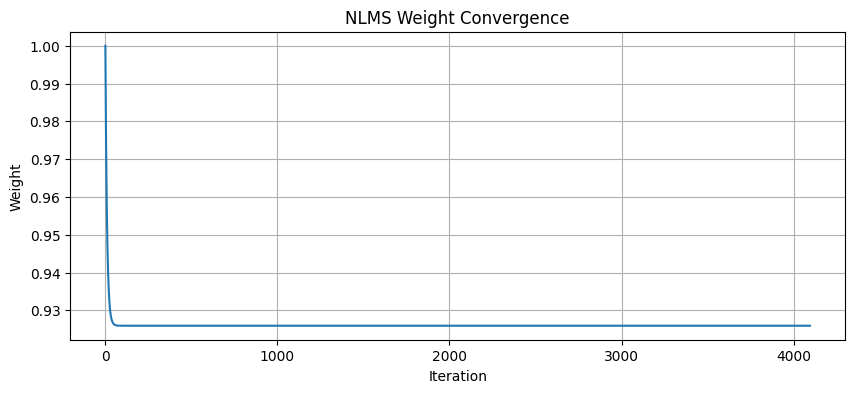

NLMS Calibrated Final Weight: 0.9259
NLMS Corrected SNDR: 79.68 dB


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# ----- Regenerate Input Signal if Needed -----
fs = 500e6
n_samples = 4096
v_fs = 1.0
tone_bin = 103
f_in = tone_bin * fs / n_samples

t = np.arange(n_samples) / fs
x = 0.5 * v_fs * np.sin(2 * np.pi * f_in * t)

# ----- NLMS Calibration -----
mu = 0.1  # Larger step size since NLMS normalizes
n_iter = len(x)
w = 1.0

# Inject static gain error
true_gain_error = 1.08
x_adc = true_gain_error * x

# Ideal reference
x_ref = x.copy()

# Histories
w_history = []
error_history = []

# NLMS Loop
for i in range(n_iter):
    norm_factor = x_adc[i]**2 + 1e-8  # Avoid divide-by-zero
    y_hat = w * x_adc[i]
    error = x_ref[i] - y_hat
    w += (mu * error * x_adc[i]) / norm_factor
    w_history.append(w)
    error_history.append(error)

# Final corrected output
x_corrected = np.array(w_history) * x_adc

# Compute SNDR
def compute_snr(signal, fs, tone_freq):
    N = len(signal)
    window = np.hanning(N)
    Xf = fft(signal * window)
    Xf = np.abs(Xf[:N // 2])**2
    signal_bin = int(tone_freq / fs * N)
    signal_power = np.sum(Xf[signal_bin-1:signal_bin+2])
    noise_power = np.sum(Xf[1:]) - signal_power
    return 10 * np.log10(signal_power / noise_power)

snr_corrected = compute_snr(x_corrected, fs, f_in)

# ----- Plots -----
plt.figure(figsize=(10,4))
plt.plot(w_history)
plt.title('NLMS Weight Convergence')
plt.xlabel('Iteration')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

print(f'NLMS Calibrated Final Weight: {w:.4f}')
print(f'NLMS Corrected SNDR: {snr_corrected:.2f} dB')


Final Weight after LMS: 0.9261
BER after LMS: 0.0000e+00
MSE after LMS: 1.0017e+03


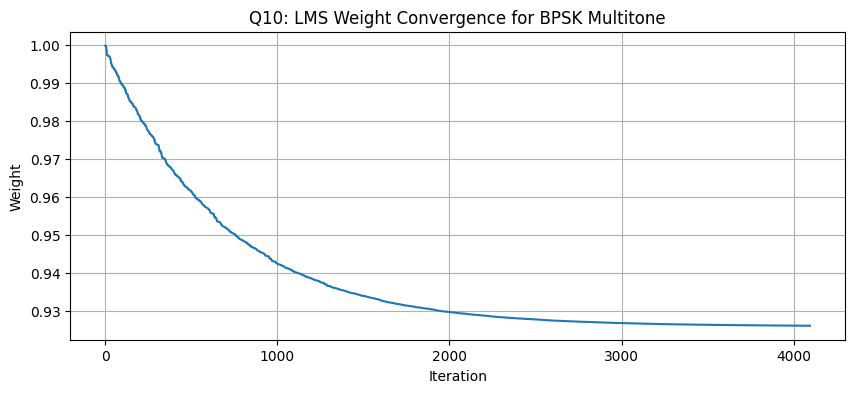

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# --- Parameters ---
fs = 500e6
n_samples = 4096
v_fs = 1.0
num_tones = 128
bandwidth = 200e6
tone_spacing = bandwidth / num_tones
tones = np.linspace(0, bandwidth, num_tones, endpoint=False)
f_in = tones

# Generate BPSK multitone signal
bsk_symbols = np.random.choice([-1, 1], size=num_tones)

def generate_bpsk_multitone(symbols, tones, fs, n_samples):
    t = np.arange(n_samples) / fs
    signal = np.zeros_like(t)
    for idx, f in enumerate(tones):
        signal += symbols[idx] * np.cos(2 * np.pi * f * t)
    return signal / np.max(np.abs(signal))  # Normalize amplitude

x = generate_bpsk_multitone(bsk_symbols, tones, fs, n_samples)

# --- Inject Static Gain Error ---
true_gain_error = 1.08
x_adc = true_gain_error * x
x_ref = x.copy()

# --- LMS Calibration ---
mu = 0.01
w = 1.0
w_history = []
n_iter = len(x)

for i in range(n_iter):
    y_hat = w * x_adc[i]
    error = x_ref[i] - y_hat
    w += mu * error * x_adc[i]
    w_history.append(w)

# Corrected signal
x_corrected = np.array(w_history) * x_adc

# --- DFT Symbol Recovery ---
def recover_symbols(signal, tones, fs, n_samples):
    Xf = fft(signal * np.hanning(n_samples))
    Xf = Xf[:n_samples // 2]
    freqs = np.fft.fftfreq(n_samples, d=1/fs)[:n_samples // 2]
    recovered = []
    for f in tones:
        idx = np.argmin(np.abs(freqs - f))
        recovered.append(np.real(Xf[idx]))
    return np.sign(recovered), np.array(recovered)

recovered_bits, recovered_values = recover_symbols(x_corrected, tones, fs, n_samples)

# --- BER and MSE Calculation ---
ber = np.mean(recovered_bits != bsk_symbols)
mse = np.mean((recovered_values - bsk_symbols)**2)

print(f'Final Weight after LMS: {w:.4f}')
print(f'BER after LMS: {ber:.4e}')
print(f'MSE after LMS: {mse:.4e}')

# --- Plot ---
plt.figure(figsize=(10,4))
plt.plot(w_history)
plt.title('Q10: LMS Weight Convergence for BPSK Multitone')
plt.xlabel('Iteration')
plt.ylabel('Weight')
plt.grid(True)
plt.show()
